<a href="https://colab.research.google.com/github/Anwarshamim01/Anamoly-Detection-in-Google-Cluster-powerdata-2019-trace-dataset/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **I performed Exploratory DAta analysis to check Data and Analyze**

In [ ]:

import numpy as np
import pandas as pd
from google.cloud import bigquery
from google.colab import auth
from google.cloud.bigquery import magics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import glob
import re
import os

**Data Retrivel From BigQuery**

---



In [ ]:

import os
data_dir = '/content/powerdata_2019/'
os.makedirs(data_dir, exist_ok=True)

%cd /content/powerdata_2019/

!gsutil -m cp gs://powerdata_2019/cell[a-j]_pdu*.csv.gz .
!gsutil -m cp gs://powerdata_2019/cell[i-j]_mvpp*.csv.gz .

!gsutil cp gs://powerdata_2019/machine_to_pdu_mapping.csv.gz .

!gunzip *.csv.gz

/content/powerdata_2019
Copying gs://powerdata_2019/cellb_pdu11.csv.gz...
Copying gs://powerdata_2019/cella_pdu6.csv.gz...
Copying gs://powerdata_2019/cella_pdu10.csv.gz...
Copying gs://powerdata_2019/cellb_pdu12.csv.gz...
Copying gs://powerdata_2019/cella_pdu7.csv.gz...
Copying gs://powerdata_2019/cellb_pdu13.csv.gz...
Copying gs://powerdata_2019/cella_pdu9.csv.gz...
Copying gs://powerdata_2019/cella_pdu8.csv.gz...
Copying gs://powerdata_2019/cellb_pdu14.csv.gz...
Copying gs://powerdata_2019/cellb_pdu15.csv.gz...
Copying gs://powerdata_2019/cellc_pdu38.csv.gz...
Copying gs://powerdata_2019/cellc_pdu39.csv.gz...
Copying gs://powerdata_2019/cellc_pdu40.csv.gz...
Copying gs://powerdata_2019/cellc_pdu41.csv.gz...
Copying gs://powerdata_2019/cellc_pdu42.csv.gz...
Copying gs://powerdata_2019/celld_pdu33.csv.gz...
Copying gs://powerdata_2019/cellc_pdu43.csv.gz...
Copying gs://powerdata_2019/celld_pdu32.csv.gz...
Copying gs://powerdata_2019/celld_pdu34.csv.gz...
Copying gs://powerdata_2019/ce

In [ ]:


# trace start time in PT (Pacific Time)
trace_start_time_pt = pd.Timestamp('2019-05-01 00:00:00', tz='America/Los_Angeles')
# to UTC
trace_start_time_utc = trace_start_time_pt.tz_convert('UTC')
print('Trace start time in UTC:', trace_start_time_utc)
# T0 is 10 minutes before the trace start time
T0 = trace_start_time_utc - pd.Timedelta(minutes=10)
print('Reference time (T0) in UTC:', T0)
# T0 is 10 minutes before the trace start time
T0 = trace_start_time_utc - pd.Timedelta(minutes=10)
print('Reference time (T0) in UTC:', T0)

Trace start time in UTC: 2019-05-01 07:00:00+00:00
Reference time (T0) in UTC: 2019-05-01 06:50:00+00:00
Reference time (T0) in UTC: 2019-05-01 06:50:00+00:00


In [ ]:




def get_power_utilization_data():
    data_dir = '/content/powerdata_2019/'
    # Include both 'pdu' and 'mvpp' files for cells 'a' to 'j'
    csv_files = glob.glob(os.path.join(data_dir, 'cell[a-j]_*.csv'))

    df_list = []

    for file in csv_files:

        filename = os.path.basename(file)
        match = re.match(r'cell([a-j])_(pdu|mvpp)(\d+)\.csv', filename)
        if match:
            cell = match.group(1)
            pdu_type = match.group(2)
            pdu_number = match.group(3)
            pdu = pdu_type + pdu_number
            df = pd.read_csv(file)
            df['cell'] = cell
            df['pdu'] = pdu
            df = df[
                (df['bad_measurement_data'] == False) &
                (df['bad_production_power_data'] == False)
            ]

            df_list.append(df)


    power_data = pd.concat(df_list, ignore_index=True)
    trace_start_time_pt = pd.Timestamp('2019-05-01 00:00:00', tz='America/Los_Angeles')

    trace_start_time_utc = trace_start_time_pt.tz_convert('UTC')

    T0 = trace_start_time_utc - pd.Timedelta(minutes=10)

    power_data['time_delta'] = pd.to_timedelta(power_data['time'], unit='us')

    power_data['time'] = T0 + power_data['time_delta']

    power_data.drop(columns=['time_delta'], inplace=True)

    power_data['time'] = power_data['time'].dt.tz_convert(None)

    power_data = power_data.sort_values('time').reset_index(drop=True)

    return power_data

power_data = get_power_utilization_data()
print('Power utilization data retrieved:', power_data.shape)

print(power_data[['time', 'cell', 'pdu', 'measured_power_util']].head())


Power utilization data retrieved: (392364, 7)
                 time cell    pdu  measured_power_util
0 2019-05-01 07:00:00    e  pdu30                0.694
1 2019-05-01 07:00:00    a  pdu10                0.699
2 2019-05-01 07:00:00    e  pdu31                0.674
3 2019-05-01 07:00:00    g   pdu5                0.786
4 2019-05-01 07:00:00    d  pdu33                0.593


In [ ]:
#  time to 5-minute bins
power_data['time'] = power_data['time'].dt.floor('5T')
# Aggregatation of  power utilization by time and PDU
power_agg = power_data.groupby(['time', 'pdu']).agg({
    'measured_power_util': 'mean',
    'production_power_util': 'mean'
}).reset_index()
def get_machine_pdu_mapping():
    data_dir = '/content/powerdata_2019/'
    file_path = os.path.join(data_dir, 'machine_to_pdu_mapping.csv')

    mapping_df = pd.read_csv(file_path)

    return mapping_df

machine_pdu_mapping = get_machine_pdu_mapping()
print('Machine-to-PDU mapping retrieved:', machine_pdu_mapping.shape)


Machine-to-PDU mapping retrieved: (96616, 3)


In [ ]:

power_data['time'] = pd.to_datetime(power_data['time'])
power_data.set_index('time', inplace=True)


power_data.sort_index(inplace=True)

print(power_data.head())


                    cell    pdu  measured_power_util  production_power_util  \
time                                                                          
2019-05-01 07:00:00    e  pdu30                0.694                  0.606   
2019-05-01 07:00:00    a  pdu10                0.699                  0.598   
2019-05-01 07:00:00    e  pdu31                0.674                  0.598   
2019-05-01 07:00:00    g   pdu5                0.786                  0.649   
2019-05-01 07:00:00    d  pdu33                0.593                  0.557   

                     bad_measurement_data  bad_production_power_data  
time                                                                  
2019-05-01 07:00:00                 False                      False  
2019-05-01 07:00:00                 False                      False  
2019-05-01 07:00:00                 False                      False  
2019-05-01 07:00:00                 False                      False  
2019-05-01 07:00:00 

In [ ]:

print(power_data.info())
print(power_data.describe())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 392364 entries, 2019-05-01 07:00:00 to 2019-06-01 06:55:00
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   cell                       392364 non-null  object 
 1   pdu                        392364 non-null  object 
 2   measured_power_util        392364 non-null  float64
 3   production_power_util      392364 non-null  float64
 4   bad_measurement_data       392364 non-null  bool   
 5   bad_production_power_data  392364 non-null  bool   
dtypes: bool(2), float64(2), object(2)
memory usage: 15.7+ MB
None
       measured_power_util  production_power_util
count        392364.000000          392364.000000
mean              0.696585               0.599914
std               0.062815               0.040369
min               0.493000               0.438000
25%               0.650000               0.576000
50%               0.702000       

cell                         0
pdu                          0
measured_power_util          0
production_power_util        0
bad_measurement_data         0
bad_production_power_data    0
dtype: int64


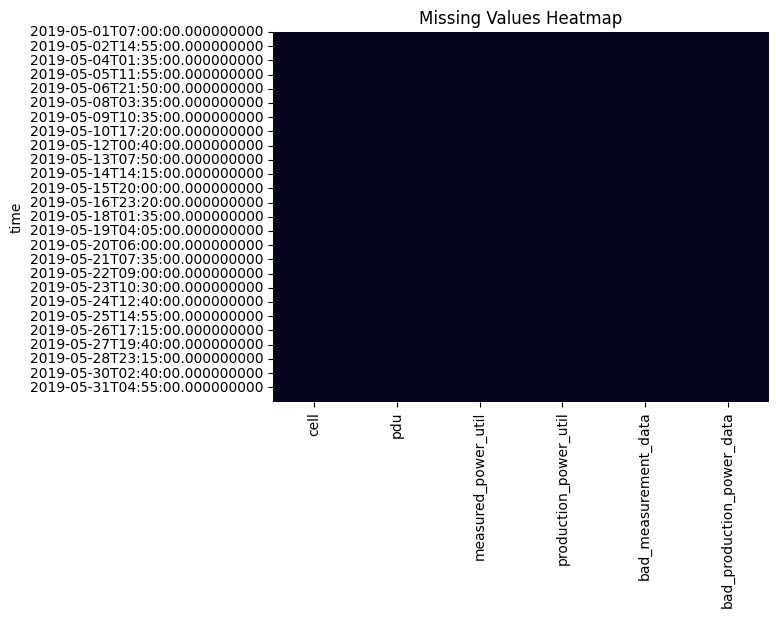

In [ ]:

import seaborn as sns
print(power_data.isnull().sum())

sns.heatmap(power_data.isnull(), cbar=False)
plt.title('Missing Values Heatmap')
plt.show()


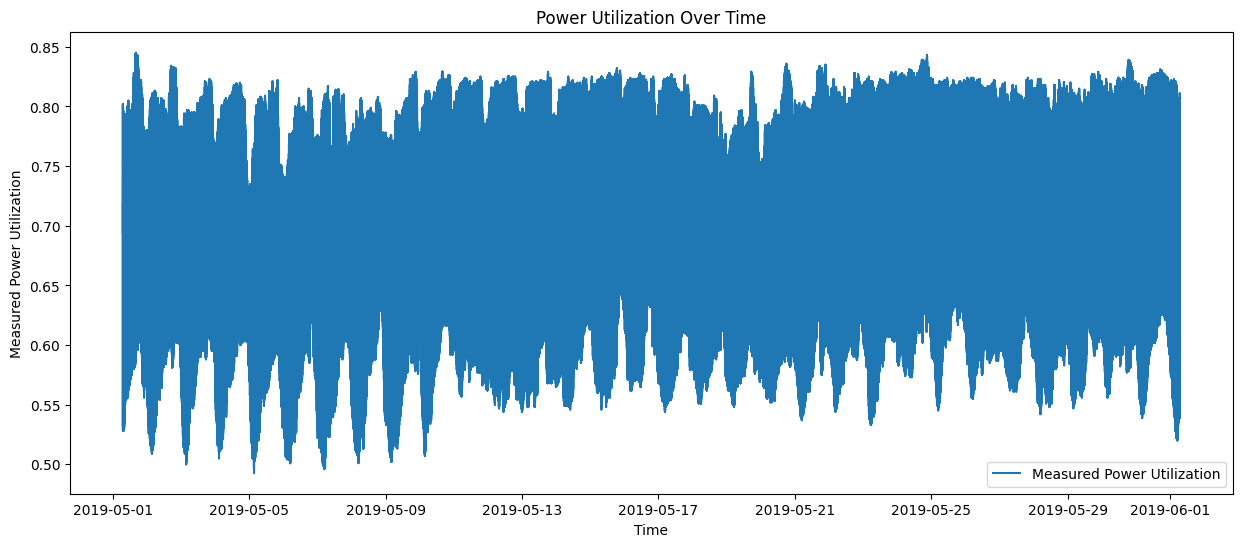

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(power_data.index, power_data['measured_power_util'], label='Measured Power Utilization')
plt.xlabel('Time')
plt.ylabel('Measured Power Utilization')
plt.title('Power Utilization Over Time')
plt.legend()
plt.show()


# **This Graph shows sequentail behaviour of power itilization **

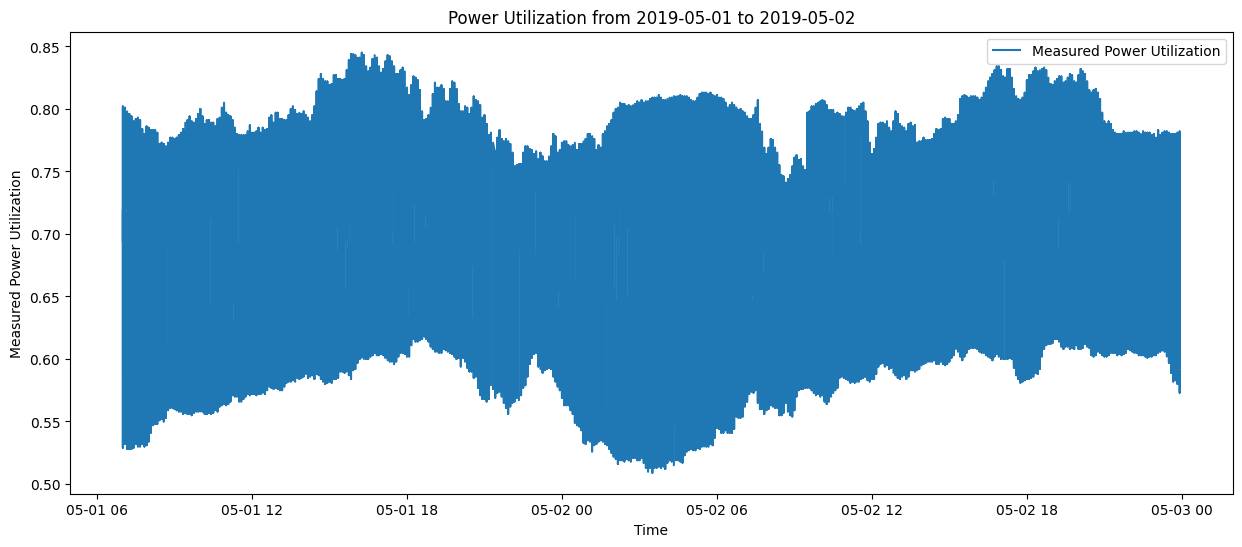

In [ ]:
# zooing into data
start_date = '2019-05-01'
end_date = '2019-05-02'

subset_data = power_data.loc[start_date:end_date]

plt.figure(figsize=(15, 6))
plt.plot(subset_data.index, subset_data['measured_power_util'], label='Measured Power Utilization')
plt.xlabel('Time')
plt.ylabel('Measured Power Utilization')
plt.title('Power Utilization from {} to {}'.format(start_date, end_date))
plt.legend()
plt.show()


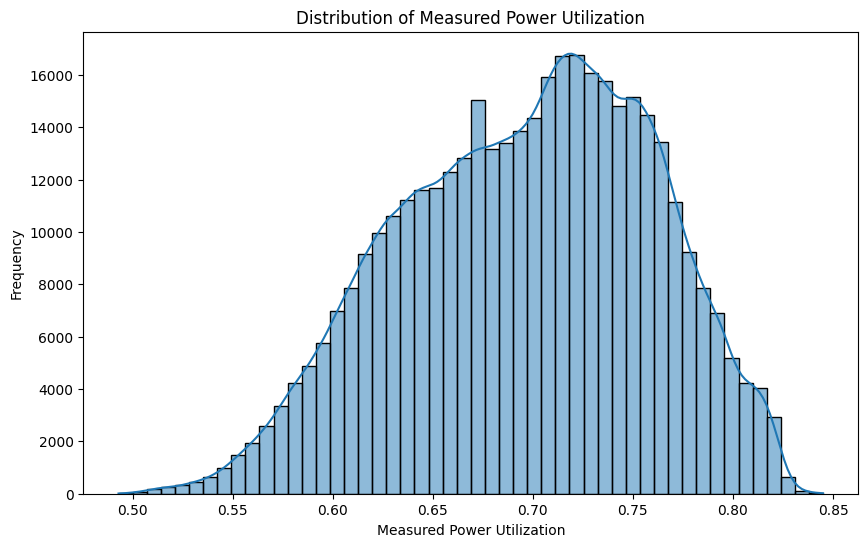

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(power_data['measured_power_util'], bins=50, kde=True)
plt.title('Distribution of Measured Power Utilization')
plt.xlabel('Measured Power Utilization')
plt.ylabel('Frequency')
plt.show()


# **above Graph is slightly skewed to the left, with a peak around 0.72 and a longer tail towards lower values. Thbis can be due to workload variations, peak usage times, and energy-saving measures and OUR INTERST ANAMOLIES**

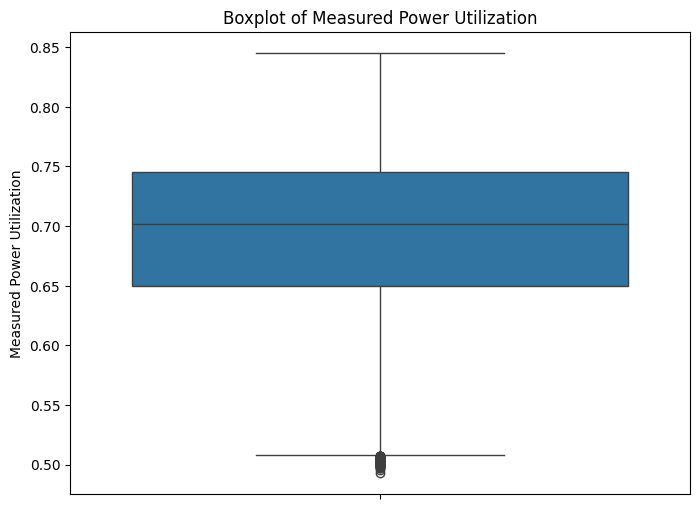

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(y=power_data['measured_power_util'])
plt.title('Boxplot of Measured Power Utilization')
plt.ylabel('Measured Power Utilization')
plt.show()


# **We see multiple outliers to the lower end **

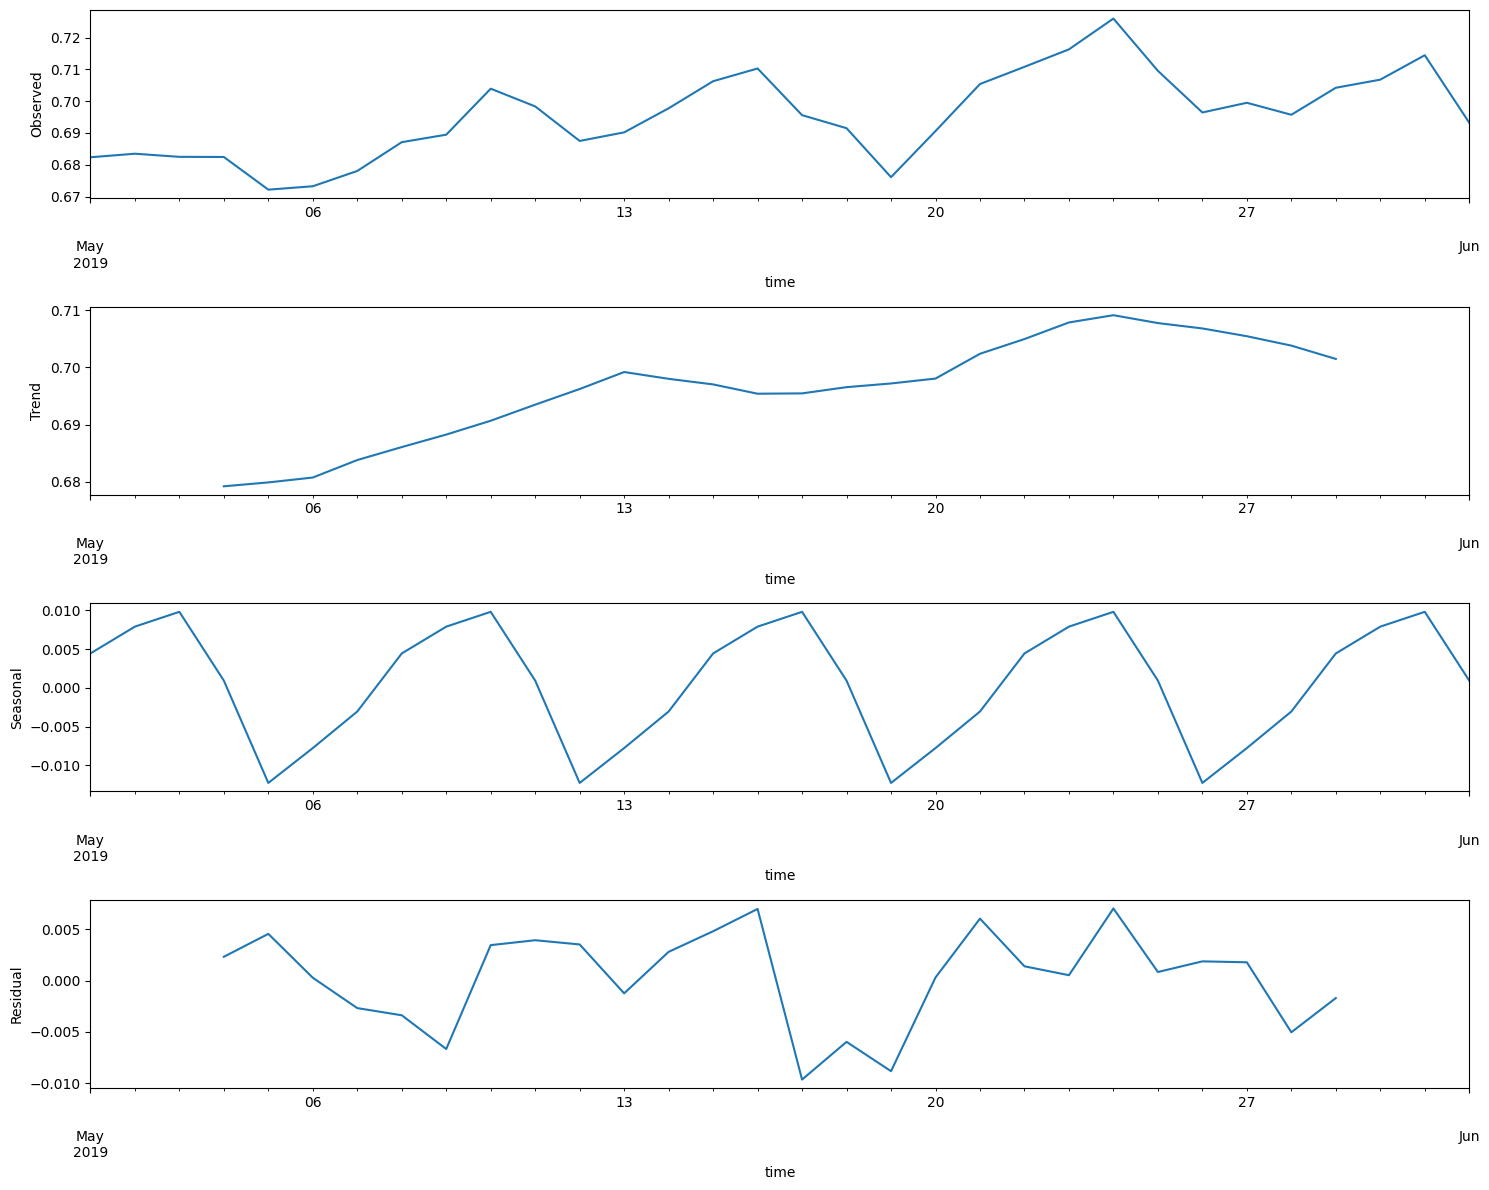

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# daily mean for decomposition
daily_power = power_data['measured_power_util'].resample('D').mean()

#seasonal decomposition
decomposition = seasonal_decompose(daily_power, model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

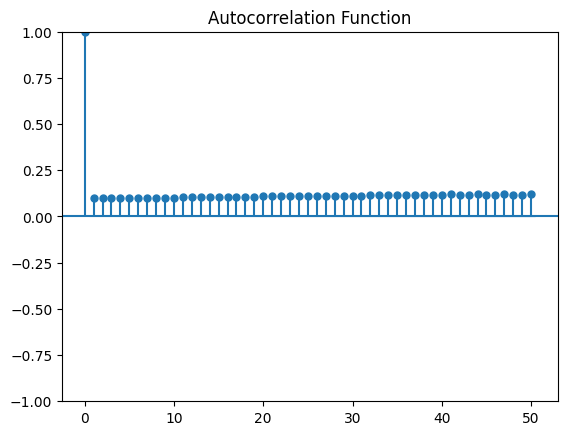

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 6))
plot_acf(power_data['measured_power_util'], lags=50)
plt.title('Autocorrelation Function')
plt.show()


<Figure size 1000x600 with 0 Axes>

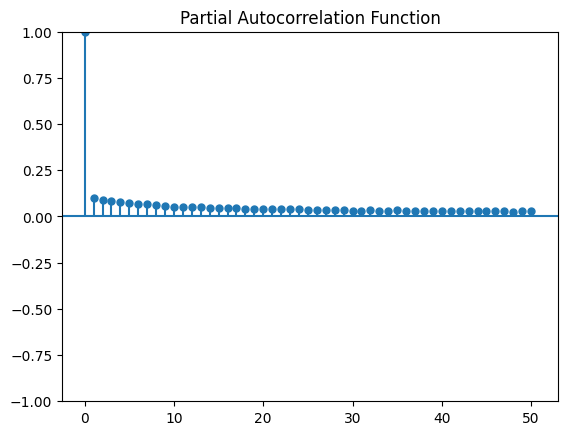

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure(figsize=(10, 6))
plot_pacf(power_data['measured_power_util'], lags=50)
plt.title('Partial Autocorrelation Function')
plt.show()


In [ ]:
power_data.dtypes

,0
cell,object
pdu,object
measured_power_util,float64
production_power_util,float64
bad_measurement_data,bool
bad_production_power_data,bool


In [ ]:
power_data['hour'] = power_data.index.hour
power_data['day_of_week'] = power_data.index.dayofweek  # Monday=0, Sunday=6
power_data['day_of_month'] = power_data.index.day
power_data['month'] = power_data.index.month


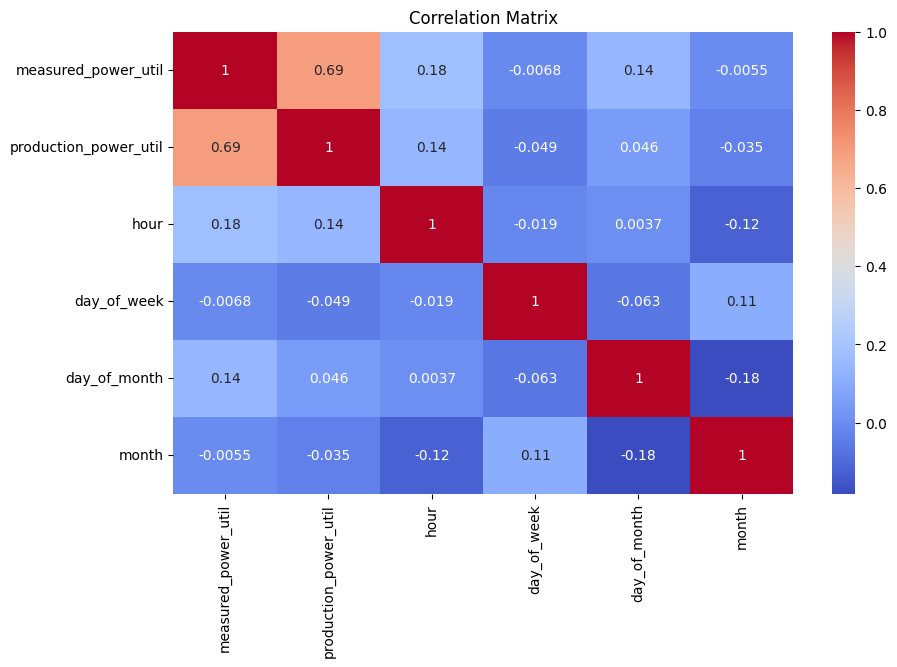

In [ ]:

numeric_data = power_data.select_dtypes(include=[np.number])

corr_matrix = numeric_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


**Hour , day of month are almost in negative corellation to every other **

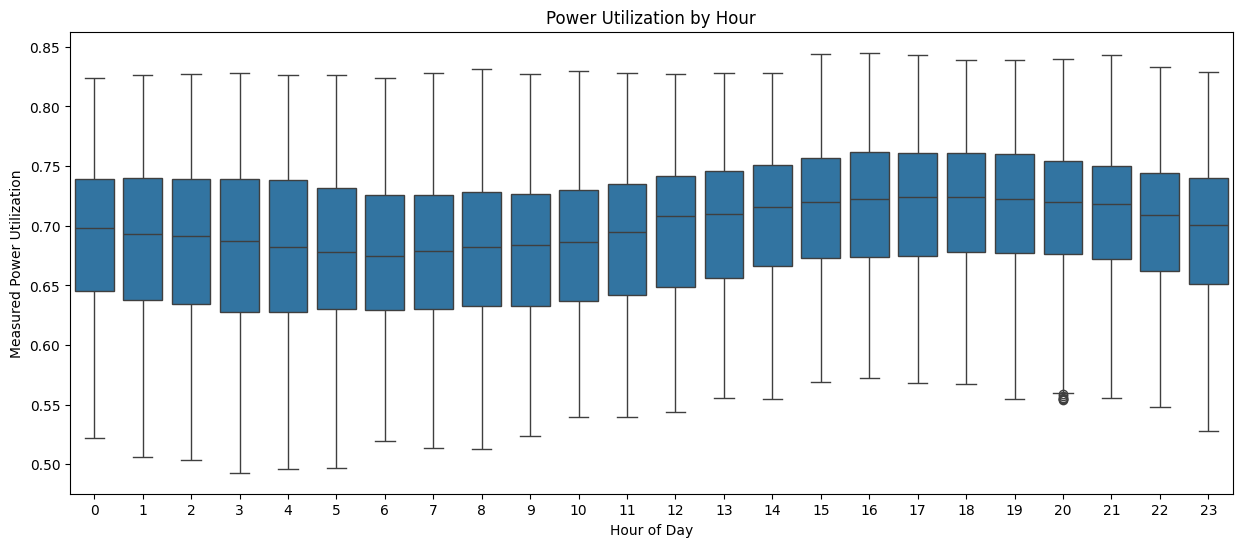

In [ ]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='hour', y='measured_power_util', data=power_data)
plt.title('Power Utilization by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Measured Power Utilization')
plt.show()


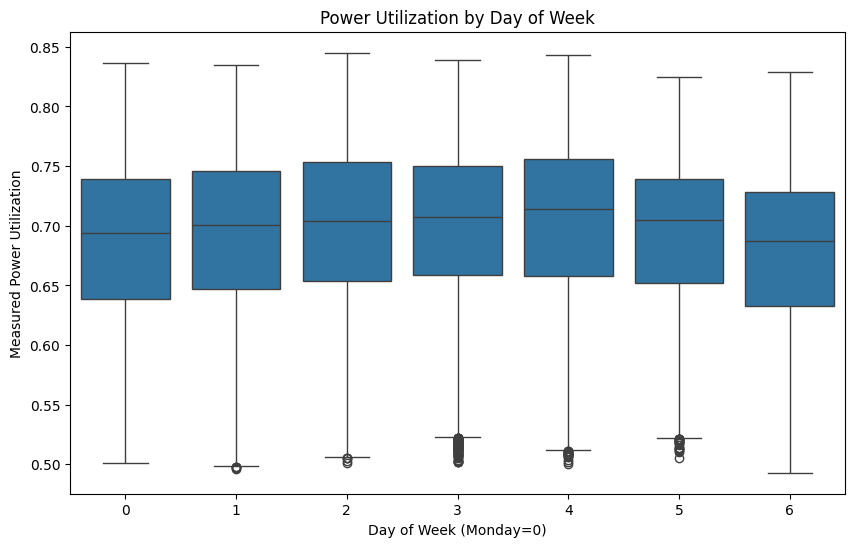

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='day_of_week', y='measured_power_util', data=power_data)
plt.title('Power Utilization by Day of Week')
plt.xlabel('Day of Week (Monday=0)')
plt.ylabel('Measured Power Utilization')
plt.show()


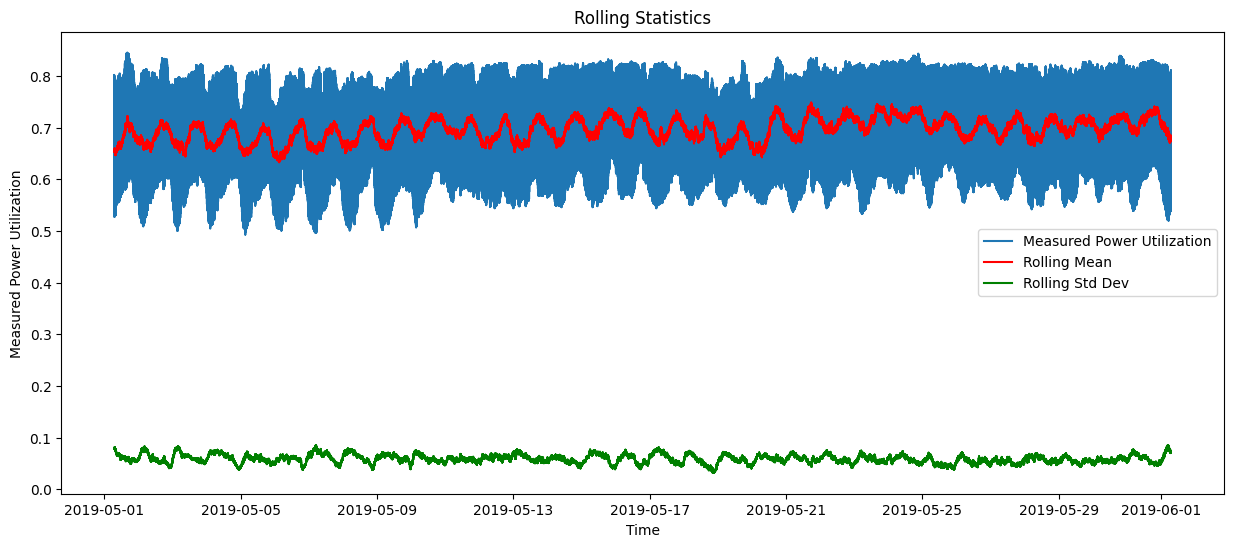

In [ ]:
window_size = 144  # e.g., 12 hours for 5-minute intervals (12 * 12)
power_data['rolling_mean'] = power_data['measured_power_util'].rolling(window=window_size).mean()
power_data['rolling_std'] = power_data['measured_power_util'].rolling(window=window_size).std()

# Plot rolling statistics
plt.figure(figsize=(15, 6))
plt.plot(power_data['measured_power_util'], label='Measured Power Utilization')
plt.plot(power_data['rolling_mean'], label='Rolling Mean', color='red')
plt.plot(power_data['rolling_std'], label='Rolling Std Dev', color='green')
plt.xlabel('Time')
plt.ylabel('Measured Power Utilization')
plt.title('Rolling Statistics')
plt.legend()
plt.show()


# **ANAMOLY detection with Z-score**

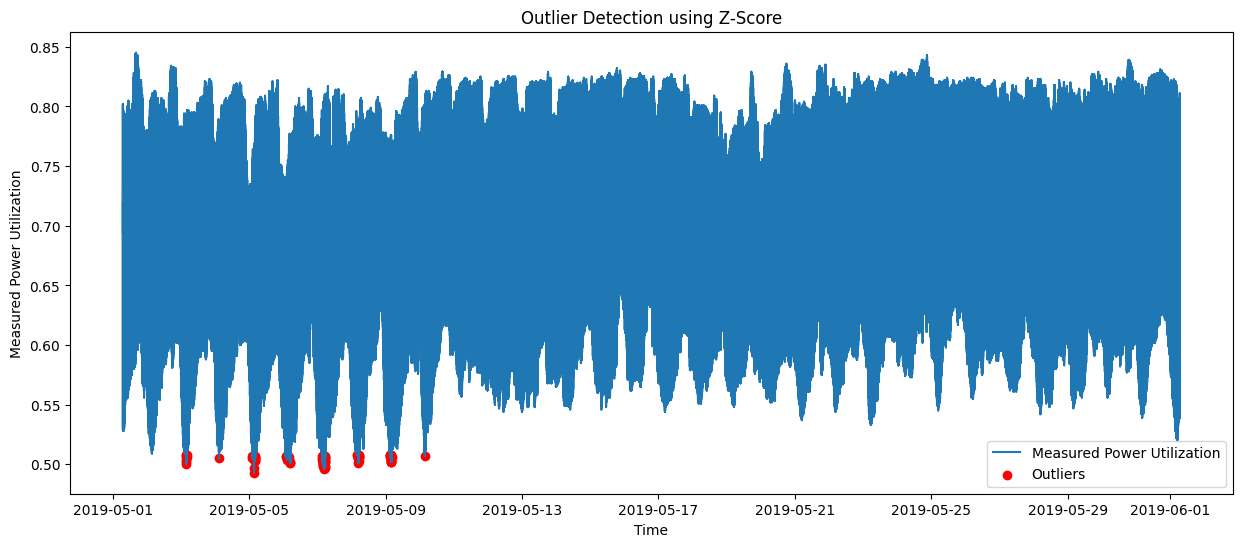

In [ ]:
from scipy import stats


power_data['z_score'] = np.abs(stats.zscore(power_data['measured_power_util']))


z_threshold = 3
outliers = power_data[power_data['z_score'] > z_threshold]

plt.figure(figsize=(15, 6))
plt.plot(power_data.index, power_data['measured_power_util'], label='Measured Power Utilization')
plt.scatter(outliers.index, outliers['measured_power_util'], color='red', label='Outliers')
plt.xlabel('Time')
plt.ylabel('Measured Power Utilization')
plt.title('Outlier Detection using Z-Score')
plt.legend()
plt.show()


# **Ananmoly with Interquartile range **

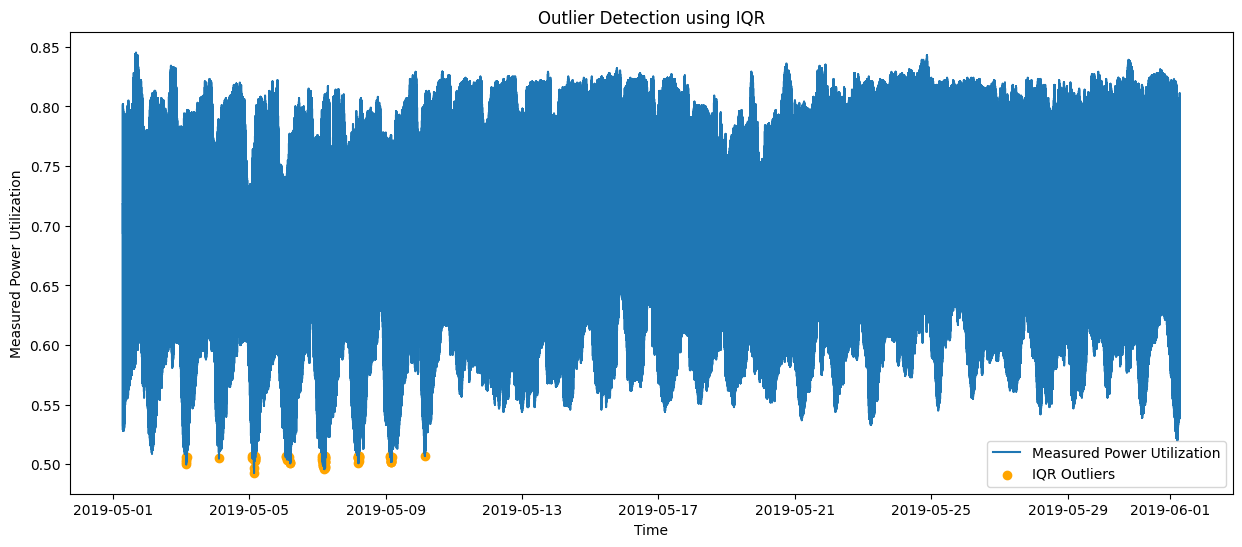

In [ ]:
Q1 = power_data['measured_power_util'].quantile(0.25)
Q3 = power_data['measured_power_util'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = power_data[(power_data['measured_power_util'] < lower_bound) | (power_data['measured_power_util'] > upper_bound)]

plt.figure(figsize=(15, 6))
plt.plot(power_data.index, power_data['measured_power_util'], label='Measured Power Utilization')
plt.scatter(outliers_iqr.index, outliers_iqr['measured_power_util'], color='orange', label='IQR Outliers')
plt.xlabel('Time')
plt.ylabel('Measured Power Utilization')
plt.title('Outlier Detection using IQR')
plt.legend()
plt.show()


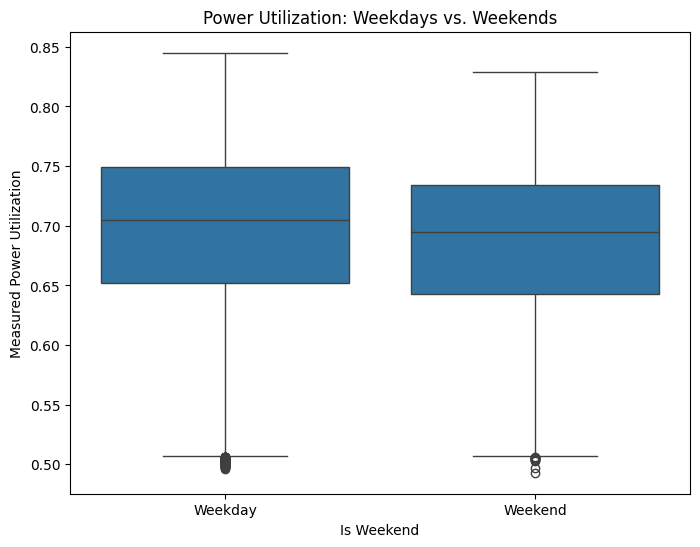

In [ ]:

power_data['is_weekend'] = power_data['day_of_week'].isin([5, 6])

# Boxplot of power utilization for weekdays vs. weekends
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_weekend', y='measured_power_util', data=power_data)
plt.title('Power Utilization: Weekdays vs. Weekends')
plt.xlabel('Is Weekend')
plt.ylabel('Measured Power Utilization')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()


In [ ]:
power_data.columns

Index(['cell', 'pdu', 'measured_power_util', 'production_power_util',
       'bad_measurement_data', 'bad_production_power_data', 'hour',
       'day_of_week', 'day_of_month', 'month', 'rolling_mean', 'rolling_std',
       'z_score', 'is_weekend'],
      dtype='object')